<a href="https://colab.research.google.com/github/poolGolez/tf-playground/blob/main/udacity/Udacity_Training_08%5D_Transfer_Learning_(Inception)_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt

Download the dataset

In [ ]:
dataset, metadata = tfds.load('tf_flowers', 
                              as_supervised=True,                            
                              split=['train[:70%]', 'train[70%:]'],
                              with_info=True)

train_dataset, val_dataset = dataset

In [ ]:
train_count = len(train_dataset)
val_count = len(val_dataset)
class_names = metadata.features['label'].names
num_classes = len(class_names)

def class_name(logit):
  return class_names[logit]

print('Training count:', train_count)
print('Validation count:', val_count)
print('Class names:', class_names)

Training count: 2569
Validation count: 1101
Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


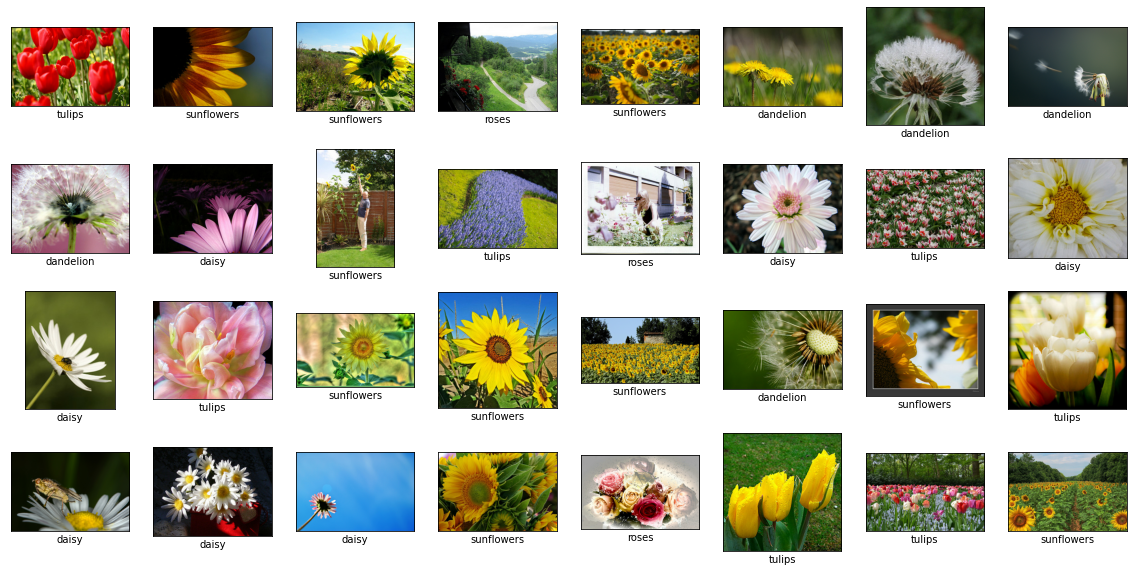

In [ ]:
plt.figure(figsize=(20, 10))
for i, (image, label_index) in enumerate(train_dataset.take(32)):
  plt.subplot(4, 8, i+1)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(class_name(label_index))

In [ ]:
BATCH_SIZE=32
IMAGE_RES=225

def normalize_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))
  image /= 255.

  return (image, label)

train_df = train_dataset.map(normalize_image).shuffle(train_count//4).batch(BATCH_SIZE)
test_df = train_dataset.map(normalize_image).batch(BATCH_SIZE)

Create the model

In [ ]:
trained_model_url = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4';
feature_extractor = hub.KerasLayer(trained_model_url, 
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3),
                                   trainable=False)

In [ ]:
model = tf.keras.Sequential([
          feature_extractor,
          tf.keras.layers.Dense(num_classes, activation='softmax')
        ])

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


Train the model

In [ ]:
EPOCHS=20
history = model.fit(train_df, epochs=EPOCHS, validation_data=test_df)

Epoch 1/20
81/81 [==============================] - 18s 219ms/step - loss: 0.0998 - accuracy: 0.9798 - val_loss: 0.0872 - val_accuracy: 0.9883
Epoch 2/20
81/81 [==============================] - 14s 163ms/step - loss: 0.0954 - accuracy: 0.9825 - val_loss: 0.0834 - val_accuracy: 0.9864
Epoch 3/20
81/81 [==============================] - 14s 164ms/step - loss: 0.0929 - accuracy: 0.9825 - val_loss: 0.0957 - val_accuracy: 0.9743
Epoch 4/20
81/81 [==============================] - 13s 162ms/step - loss: 0.0796 - accuracy: 0.9883 - val_loss: 0.0713 - val_accuracy: 0.9903
Epoch 5/20
81/81 [==============================] - 13s 161ms/step - loss: 0.0752 - accuracy: 0.9910 - val_loss: 0.0733 - val_accuracy: 0.9891
Epoch 6/20
81/81 [==============================] - 13s 162ms/step - loss: 0.0747 - accuracy: 0.9872 - val_loss: 0.0659 - val_accuracy: 0.9922
Epoch 7/20
81/81 [==============================] - 18s 219ms/step - loss: 0.0665 - accuracy: 0.9910 - val_loss: 0.0633 - val_accuracy: 0.9938

Explore predictions

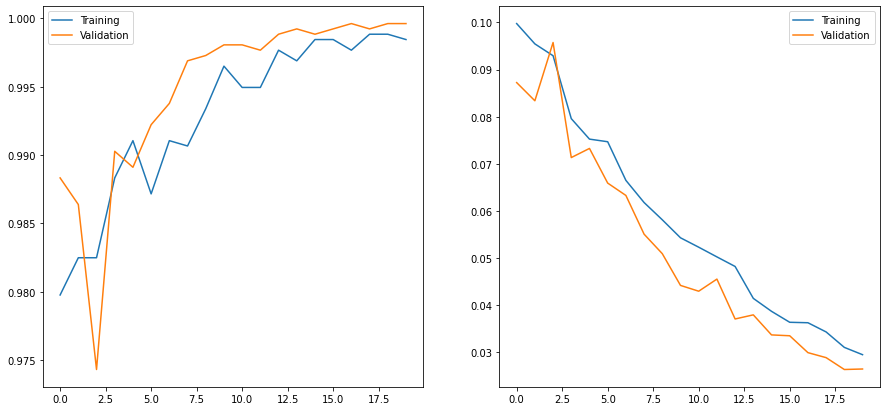

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = history.epoch

plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
plt.plot(epochs, accuracy, label='Training')
plt.plot(epochs, val_accuracy, label='Validation')

plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()

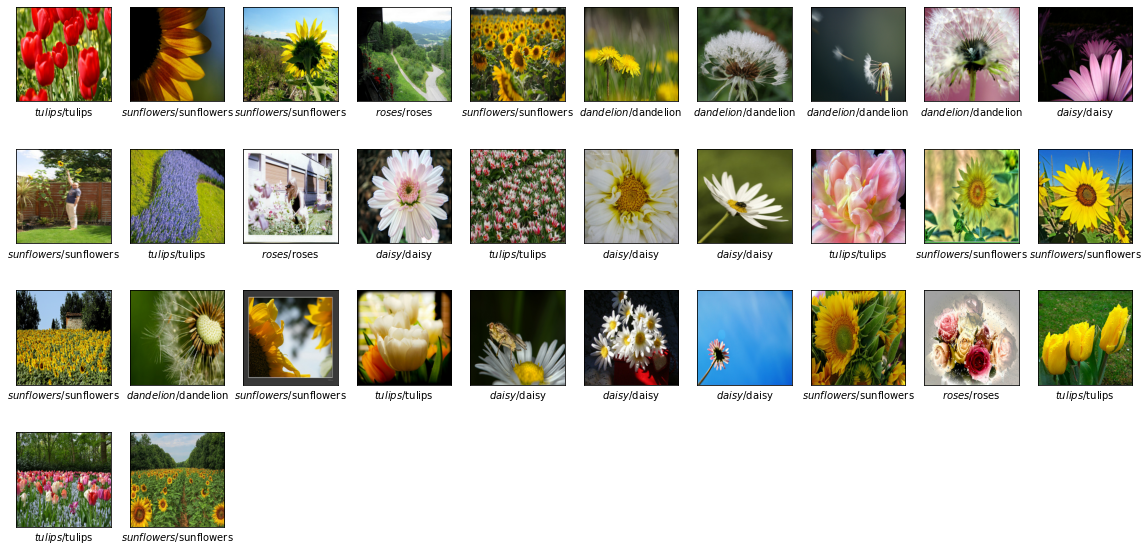

In [ ]:
plt.figure(figsize=(20, 10))

def x(probabilities):
  label_id = np.argmax(probabilities)
  return class_name(label_id)

test_images, test_labels = next(iter(test_df.take(1)))
test_labels = [class_name(i) for i in test_labels]
prediction_prob = model.predict(test_data)
predictions = list(map(x, prediction_prob))

for i, (image, label, prediction) in enumerate(zip(test_images, test_labels, predictions)):
  plt.subplot(4, 10, i+1)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(f"${label}/${prediction}", color='black' if (label==prediction) else 'red')
